# Predicting "GOOGLE/MSFT/AMZN/.." stock price with stacked LSTM layers

### Extracting the GOOGLE stock data 

In [6]:
import pandas_datareader as pdr
key="a8374f9c55f6ba0853d304bd4cadc3a4775b523d"

In [60]:
df = pdr.get_data_tiingo('MSFT', api_key=key)

C:\Users\kashy\AppData\Roaming\Python\Python39\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [61]:
df.to_csv('GOOGL.csv')

In [62]:
import pandas as pd
df=pd.read_csv('GOOGL.csv')

In [65]:
df.head(10)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,MSFT,2018-07-20 00:00:00+00:00,106.27,108.20,106.08,108.08,56038827,100.479158,102.303989,100.299511,102.190528,56038827,0.0,1.0
1,MSFT,2018-07-23 00:00:00+00:00,107.97,108.14,106.13,106.30,29706955,102.086522,102.247258,100.346787,100.507523,29706955,0.0,1.0
2,MSFT,2018-07-24 00:00:00+00:00,107.66,108.82,107.26,108.57,26316619,101.793414,102.890204,101.415211,102.653827,26316619,0.0,1.0
3,MSFT,2018-07-25 00:00:00+00:00,110.83,111.15,107.60,107.96,30798058,104.790675,105.093238,101.736684,102.077067,30798058,0.0,1.0
4,MSFT,2018-07-26 00:00:00+00:00,109.62,111.00,109.50,110.74,31372110,103.646610,104.951412,103.533149,104.705580,31372110,0.0,1.0
5,MSFT,2018-07-27 00:00:00+00:00,107.68,110.18,106.14,110.18,37005292,101.812324,104.176095,100.356242,104.176095,37005292,0.0,1.0
6,MSFT,2018-07-30 00:00:00+00:00,105.37,107.53,104.76,107.19,34668327,99.628200,101.670498,99.051440,101.349025,34668327,0.0,1.0
7,MSFT,2018-07-31 00:00:00+00:00,106.08,106.72,105.38,106.49,27655152,100.299511,100.904637,99.637656,100.687170,27655152,0.0,1.0
8,MSFT,2018-08-01 00:00:00+00:00,106.28,106.45,105.42,106.03,23628699,100.488613,100.649349,99.675476,100.252236,23628699,0.0,1.0
9,MSFT,2018-08-02 00:00:00+00:00,107.57,108.09,104.84,105.40,26104258,101.708319,102.199983,99.127081,99.656566,26104258,0.0,1.0


In [66]:
df1=df.reset_index()['close']

In [67]:
df1

0       106.27
1       107.97
2       107.66
3       110.83
4       109.62
         ...  
1250    332.47
1251    337.20
1252    342.66
1253    345.24
1254    345.73
Name: close, Length: 1255, dtype: float64

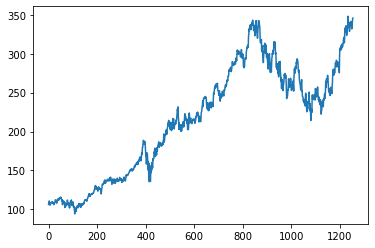

In [68]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(df1)

### Preprocess the data to be used for LSTM

In [69]:
# Scaling the Data from in the range of (0,1) as LSTM is quite sensitive the the scales.

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [70]:
print(df1)

[[0.04780092]
 [0.05449463]
 [0.05327401]
 ...
 [0.97858015]
 [0.98873883]
 [0.99066819]]


In [71]:
#splitting dataset into train and test split.

training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [73]:
training_size, test_size

(815, 440)

In [74]:
train_data, test_data

(array([[0.04780092],
        [0.05449463],
        [0.05327401],
        [0.0657558 ],
        [0.06099146],
        [0.05335276],
        [0.0442572 ],
        [0.0470528 ],
        [0.0478403 ],
        [0.05291964],
        [0.05477025],
        [0.05512462],
        [0.05807773],
        [0.06047958],
        [0.06118833],
        [0.05855022],
        [0.05543962],
        [0.06075521],
        [0.05327401],
        [0.05319526],
        [0.05295901],
        [0.05016341],
        [0.04665905],
        [0.05091152],
        [0.05288026],
        [0.05618774],
        [0.06091271],
        [0.06351144],
        [0.07044139],
        [0.07016577],
        [0.07166201],
        [0.06922077],
        [0.05654211],
        [0.05752648],
        [0.05543962],
        [0.06004646],
        [0.06737016],
        [0.06922077],
        [0.07394574],
        [0.07575698],
        [0.07091389],
        [0.07512698],
        [0.0691814 ],
        [0.07654447],
        [0.07926133],
        [0

In [75]:
# convert the array of values into a dataset matrix with the function 'create_dataset'

def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]               ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)


### Creating array for test_data and train_data

In [76]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [77]:
print(X_train.shape), print(y_train.shape)

(714, 100)
(714,)


(None, None)

In [78]:
print(X_test.shape), print(y_test.shape)

(339, 100)
(339,)


(None, None)

In [79]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Creating the tripple Stacked LSTM mofdel for prediction

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [81]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Fitting the data to the created Model

In [83]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 12s 404ms/step - loss: 0.0560 - val_loss: 0.0349
Epoch 2/100
12/12 [==============================] - 3s 253ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 3/100
12/12 [==============================] - 3s 255ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 4/100
12/12 [==============================] - 3s 256ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 5/100
12/12 [==============================] - 3s 250ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 6/100
12/12 [==============================] - 3s 255ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 7/100
12/12 [==============================] - 3s 259ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 8/100
12/12 [==============================] - 3s 255ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 9/100
12/12 [==============================] - 3s 253ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 10/100
12/12 [==============================] - 3s 253ms/step - loss: 0.0010 - val_l

12/12 [==============================] - 3s 258ms/step - loss: 4.7492e-04 - val_loss: 0.0017
Epoch 80/100
12/12 [==============================] - 3s 259ms/step - loss: 5.1502e-04 - val_loss: 0.0018
Epoch 81/100
12/12 [==============================] - 3s 257ms/step - loss: 4.5865e-04 - val_loss: 0.0016
Epoch 82/100
12/12 [==============================] - 3s 259ms/step - loss: 4.7371e-04 - val_loss: 0.0016
Epoch 83/100
12/12 [==============================] - 3s 259ms/step - loss: 4.5820e-04 - val_loss: 0.0019
Epoch 84/100
12/12 [==============================] - 3s 257ms/step - loss: 4.7962e-04 - val_loss: 0.0016
Epoch 85/100
12/12 [==============================] - 3s 252ms/step - loss: 5.0769e-04 - val_loss: 0.0017
Epoch 86/100
12/12 [==============================] - 3s 259ms/step - loss: 4.8974e-04 - val_loss: 0.0015
Epoch 87/100
12/12 [==============================] - 3s 260ms/step - loss: 4.6691e-04 - val_loss: 0.0018
Epoch 88/100
12/12 [==============================] - 3s 25

In [84]:
import tensorflow as tf
tf.__version__

'2.13.0'

### Now it's time to check prediction ability of the model on X_train and X_test

In [85]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 1s 52ms/step


In [86]:
train_predict, test_predict

(array([[0.0621497 ],
        [0.06136754],
        [0.0606712 ],
        [0.05965379],
        [0.05775895],
        [0.05519413],
        [0.05224277],
        [0.04889238],
        [0.04486645],
        [0.03974883],
        [0.0348056 ],
        [0.03082488],
        [0.02800968],
        [0.0265239 ],
        [0.02617566],
        [0.02612118],
        [0.02664237],
        [0.02774288],
        [0.0293863 ],
        [0.03160927],
        [0.03411492],
        [0.03648862],
        [0.03835611],
        [0.04003182],
        [0.04165874],
        [0.04334566],
        [0.04529271],
        [0.04711141],
        [0.04874009],
        [0.0500205 ],
        [0.05104446],
        [0.05150929],
        [0.05103674],
        [0.05022183],
        [0.0490901 ],
        [0.04751014],
        [0.04605369],
        [0.04522068],
        [0.04494397],
        [0.04498199],
        [0.04523393],
        [0.04553764],
        [0.04606561],
        [0.04680961],
        [0.04771045],
        [0

In [87]:
##Transform back the data into its original form

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [88]:
train_predict, test_predict

(array([[109.914154],
        [109.715515],
        [109.538666],
        [109.28027 ],
        [108.79904 ],
        [108.14765 ],
        [107.398094],
        [106.547195],
        [105.524734],
        [104.22501 ],
        [102.969574],
        [101.958595],
        [101.243614],
        [100.86628 ],
        [100.77783 ],
        [100.764   ],
        [100.89636 ],
        [101.17586 ],
        [101.59324 ],
        [102.157814],
        [102.79417 ],
        [103.39701 ],
        [103.8713  ],
        [104.29688 ],
        [104.710075],
        [105.1385  ],
        [105.63299 ],
        [106.09489 ],
        [106.508514],
        [106.83371 ],
        [107.09376 ],
        [107.211815],
        [107.0918  ],
        [106.884834],
        [106.59741 ],
        [106.19615 ],
        [105.826256],
        [105.6147  ],
        [105.544426],
        [105.55407 ],
        [105.61806 ],
        [105.6952  ],
        [105.829285],
        [106.018234],
        [106.24702 ],
        [1

In [89]:
# RMSE performance check on trained data

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

192.5477220271492

In [90]:
# RMSE performance check on test data

math.sqrt(mean_squared_error(y_test,test_predict))

268.9871299574186

### Plotting up all-together (original, test_predict, train_predict)

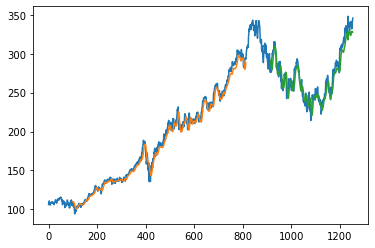

In [91]:
# shift train predictions for plotting

look_back=100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict


# shift test predictions for plotting

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Now Predicting for next 10 days

In [92]:
len(test_data)

440

In [93]:
test_data.shape

(440, 1)

In [94]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [95]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [43]:
# Impact of reshape function 

x= np.arange(0,50)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [46]:
x= x.reshape(-1, 1)
x

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49]])

In [96]:
len(temp_input)

100

### predicting for next 10 days

In [97]:

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:                                                  # will be used only for first iteration
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.932801]
101
1 day input [0.63251565 0.61066268 0.6143639  0.61145017 0.59904713 0.6181045
 0.63456314 0.64078434 0.63007442 0.62830256 0.62286884 0.60818207
 0.6291688  0.65621924 0.67452849 0.7168957  0.72961373 0.70126393
 0.70736701 0.70150018 0.72264441 0.73410245 0.71760444 0.71307635
 0.7338662  0.74780486 0.76453912 0.76032602 0.76012915 0.74894673
 0.77753278 0.76883096 0.74300114 0.74559987 0.77060283 0.75603418
 0.76650786 0.76481474 0.76512974 0.75591605 0.75453794 0.73882742
 0.71382447 0.79237705 0.82962555 0.83919361 0.8324999  0.83190928
 0.82793243 0.83190928 0.85254164 0.84466669 0.83816986 0.85907784
 0.8504154  0.84592668 0.84785605 0.85683348 0.86573217 0.88352955
 0.88282081 0.89400323 0.87069339 0.86514155 0.91266685 0.94011104
 0.93349608 0.92239241 0.93889042 0.94999409 0.95212033 0.94322164
 0.90266567 0.91006812 0.91609245 0.93601606 0.9456235  0.95763279
 1.         0.97728078 0.9604284  0.94274914 0.9669646  0.94849785
 0.92321928 0.94672599 0.95176596 0.

8 day output [[0.8724102]]
9 day input [0.63007442 0.62830256 0.62286884 0.60818207 0.6291688  0.65621924
 0.67452849 0.7168957  0.72961373 0.70126393 0.70736701 0.70150018
 0.72264441 0.73410245 0.71760444 0.71307635 0.7338662  0.74780486
 0.76453912 0.76032602 0.76012915 0.74894673 0.77753278 0.76883096
 0.74300114 0.74559987 0.77060283 0.75603418 0.76650786 0.76481474
 0.76512974 0.75591605 0.75453794 0.73882742 0.71382447 0.79237705
 0.82962555 0.83919361 0.8324999  0.83190928 0.82793243 0.83190928
 0.85254164 0.84466669 0.83816986 0.85907784 0.8504154  0.84592668
 0.84785605 0.85683348 0.86573217 0.88352955 0.88282081 0.89400323
 0.87069339 0.86514155 0.91266685 0.94011104 0.93349608 0.92239241
 0.93889042 0.94999409 0.95212033 0.94322164 0.90266567 0.91006812
 0.91609245 0.93601606 0.9456235  0.95763279 1.         0.97728078
 0.9604284  0.94274914 0.9669646  0.94849785 0.92321928 0.94672599
 0.95176596 0.94861598 0.9702327  0.96019215 0.96082214 0.97310706
 0.95716029 0.93593732 

In [98]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

In [99]:
len(df1)

1255

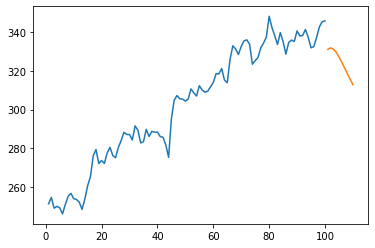

In [101]:
plt.plot(day_new,scaler.inverse_transform(df1[1155:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

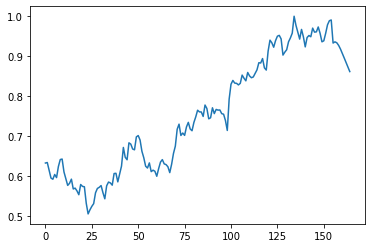

In [102]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1100:])